In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

/home/betty35/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0414 20:56:32.175670 139649523025664 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [5]:
data_source = 'output/sub-set/'
file_name = 'Fire HD'+'.csv'
df = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False)
reviews = pd.DataFrame(df['text'])

In [12]:
reviews['POS'] = reviews.text.apply(lambda x: pos_tagger.tag(x.split()))

In [14]:
reviews.to_csv(r'/mnt/doc/School/USYD/Capstone/workspace/data_testing/output/sub-set/fireHD-tag.csv',sep='\t')

In [16]:
reviews['POS'][0:10].tolist()

[[('I', 'PRP'),
  ('find', 'VBP'),
  ('that', 'DT'),
  ('is', 'VBZ'),
  ('not', 'RB'),
  ('as', 'RB'),
  ('easy', 'JJ'),
  ('to', 'TO'),
  ('use', 'VB'),
  ('as', 'IN'),
  ('my', 'PRP$'),
  ('regular', 'JJ'),
  ('Kindle', 'NNP'),
  ('Fire', 'NNP')],
 [('When', 'WRB'),
  ('I', 'PRP'),
  ('am', 'VBP'),
  ('reading', 'VBG'),
  ('the', 'DT'),
  ('kindle', 'NN'),
  ('it', 'PRP'),
  ('freezes', 'VBZ'),
  ('up', 'RP'),
  ('-LRB-', '-LRB-'),
  ('because', 'IN'),
  ('you', 'PRP'),
  ('hold', 'VBP'),
  ('it', 'PRP'),
  ('on', 'IN'),
  ('the', 'DT'),
  ('side', 'NN'),
  ('-RRB-', '-RRB-')],
 [('Also', 'RB'),
  ('you', 'PRP'),
  ('have', 'VBP'),
  ('to', 'TO'),
  ('get', 'VB'),
  ('out', 'IN'),
  ('of', 'IN'),
  ('it', 'PRP'),
  ('to', 'TO'),
  ('brighten', 'VB'),
  ('or', 'CC'),
  ('darken', 'VB'),
  ('your', 'PRP$'),
  ('text', 'NN'),
  ('that', 'IN'),
  ('you', 'PRP'),
  ('are', 'VBP'),
  ('reading', 'VBG')],
 [('Lastly', 'RB'),
  (',', ','),
  ('the', 'DT'),
  ('advertisements', 'NNS'),
  ('th

In [17]:
def getMainWords(pos):
    result = '';
    for x in pos:
        if x[1][0:2] in ['NN','VB']:
            result= result+x[0]+' '
    if len(result)>0:
        result= result[0:len(result)-1]
    return result

reviews['main'] = list(map(getMainWords,reviews['POS']))
reviews = reviews.loc[reviews['main'].apply(len)>0,['text','main']] #filtering out sentences without any nouns or verbs

reviews = reviews.reset_index(drop=True)# reset index

In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'fireHD-tag'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text','main']]
###################################################

In [3]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

Instructions for updating:
Colocations handled automatically by placer.


W0414 20:56:37.427887 139649523025664 deprecation.py:323] From /home/betty35/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['sentence_embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
    end_time1=time.time()
    reviews['words_embedding'] = pd.Series(list(session.run(embed(list(reviews['main'])))))
    end_time2=time.time()
    print('time1:',(end_time1-start_time),' time2:',(end_time2-end_time1))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 21:00:46.809165 139649523025664 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 21:00:51.614130 139649523025664 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 5.631831884384155  time2: 3.5516698360443115


In [24]:
#sub=reviews.loc[:,['text','main']]
#sub.to_csv(r'/mnt/doc/School/USYD/Capstone/workspace/data_testing/output/sub-set/fireHD-tag.csv',sep='\t')

In [5]:
# Preparing datasets
X1 = np.array(reviews['sentence_embedding'].tolist())
X2 = np.array(reviews['words_embedding'].tolist())
n_sentence = len(X1.tolist())

In [9]:
####greedy
corr = np.inner(X1,X1)


In [149]:
corr[corr<0]=0
corr[corr>0.99]=0

In [150]:
result = np.where(corr == np.amax(corr))
result[0]

array([1193, 1648])

In [152]:
corr[1193,1648]

0.98969424

In [151]:
print(reviews['text'][1193])
print(reviews['text'][1648])

I absolutely love my Kindle Fire HD
I love my Kindle Fire HD


In [153]:
corr_maxes = np.amax(corr,axis=1)
corr_mins = np.amin(corr,axis=1)
avg_corr = sum(sum(corr))/n_sentence/n_sentence
avg_max_corr = sum(corr_maxes) / n_sentence
avg_min_corr = sum(corr_mins) / n_sentence
print('avg max corr:{}, avg min corr:{}. avg corr:{}'.format(avg_max_corr, avg_min_corr, avg_corr))

avg max corr:0.7546270884984296, avg min corr:0.0. avg corr:0.2823016060312656


In [154]:
corr_min_of_max = np.amin(corr_maxes)
corr_min_of_max

0.39729232

In [155]:
np.amax(corr)

0.98969424

In [209]:
labels = np.zeros(shape=n_sentence, dtype=np.int8)
chain = np.zeros(shape=n_sentence, dtype=np.int8)

the_line = 0.85#0.9*avg_max_corr+0.1*avg_corr
the_line

0.85

In [174]:
np.where(corr > the_line)[0].shape[0]/(n_sentence*n_sentence)

0.007420381529003356

In [203]:
pairs = np.where(corr > 0.85)

In [208]:
my_i=4
print(reviews['text'][pairs[0][my_i]])
print(reviews['text'][pairs[1][my_i]])

Previously I had to read my Kindle books on my phone, but this is much better
I really like my new Kindle


In [224]:
def find_close_pt_with_label(s): # s: the index of the sentence
    for i in range(0, n_sentence):
        if corr[s][i]>the_line and labels[i]!=0:
            return i,labels[i]
    return 0, 0

def group_labels(labels):
    clusters = []
    for i in range(-1,np.amax(labels)):
        index = np.where(labels == i)
        clusters.append(index[0])
    return clusters

In [232]:
label_count = 1
current_label=0

for i in range(0,n_sentence):
    if np.amax(corr[i])<0.85:
        labels[i] = -1 
        continue
    #######check if we should skip to next ####################
    if labels[i]!= 0: # if i already has a label
        continue
    ######or need to find the current sentence a label########
    else:
        (index_, temp) = find_close_pt_with_label(i) # try to find i an existing label
        if temp!=0:
            labels[i] = temp
            chain[i] = 1+chain[index_]
            if chain[i]>1: #1: # does not allow 2+ chain
                labels[i] = label_count
                label_count = label_count+1
        else:
            labels[i] = label_count # else, assign a new label
            label_count = label_count+1
    ###### finished assigning the current sentence a label#########
    
    current_label = labels[i]
    ###### move on to spread the label  ###########################
    for j in range(i, n_sentence):
        if labels[j]!=0: # if j already has a label
            continue # skip
        if corr[i][j]>the_line: # if sentence i is similar to sentence j enough
            if labels[j]==0: # if sentence j doesn't have a label
                labels[j] = current_label
                

In [233]:
clusters = group_labels(labels)

In [234]:
len(clusters)

128

In [235]:
clusters

[array([   1,    2,    3, ..., 3350, 3353, 3354]),
 array([], dtype=int64),
 array([   0, 2481, 3078, 3287]),
 array([1374, 2208]),
 array([], dtype=int64),
 array([2484, 3029]),
 array([   4,  542, 1481, 1663]),
 array([], dtype=int64),
 array([ 545,  551, 2213, 3294]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2492]),
 array([2767]),
 array([], dtype=int64),
 array([1391]),
 array([], dtype=int64),
 array([2224]),
 array([ 280,  475, 1048, 1128, 1649, 2958]),
 array([2500]),
 array([  19,  560, 2770]),
 array([2503, 2776]),
 array([ 562, 1502]),
 array([  22,  159,  678,  778, 1166, 1545, 2468, 2742, 2980, 3095]),
 array([  23,  120,  290,  564,  681,  844,  946, 1009, 2233]),
 array([845]),
 array([ 566,  694, 1236, 1865, 2508, 3313]),
 array([ 536, 1403, 3314]),
 array([1113]),
 array([293, 489]),
 array([2512, 3056, 3317]),
 array([ 295, 1436, 1577, 1690]),
 array([3058]),
 array([2516, 3320]),
 array([ 298,  764, 1

In [229]:
clusters[1].shape[0]

0

In [230]:
loose = []
remove_group = []
for i in range(0,len(clusters)):
    if clusters[i].shape[0]<10:
        for j in range(0,clusters[i].shape[0]):
            loose.append(clusters[i][j])
        remove_group.append(i)
        
loose = np.array(loose)

In [231]:
clusters = np.array(clusters)
clusters = np.delete(clusters, remove_group, 0)
clusters = clusters.tolist()
clusters.append(loose)

In [216]:
clusters

[array([ 262,  819, 1084, 1372, 1658, 1938, 2206, 2479, 2754, 3025, 3287]),
 array([   0,  263,  537,  820, 1085, 1373, 1659, 1939, 2207, 2481, 2755,
        3026, 3078, 3288]),
 array([   1,  264,  538,  822, 1086, 1374, 1660, 1940, 2208, 2482, 2756,
        3027, 3289]),
 array([   2,  265,  539,  823, 1087, 1376, 1661, 1941, 2209, 2483, 2757,
        3028, 3290]),
 array([   3,  266,  541,  824, 1089, 1377, 1662, 1942, 2210, 2484, 2758,
        3029, 3291]),
 array([   4,  267,  542,  825, 1090, 1379, 1481, 1663, 1943, 2211, 2485,
        2759, 3030, 3292]),
 array([   5,  268,  543,  826, 1091, 1380, 1664, 1944, 2212, 2486, 2760,
        3031, 3293]),
 array([   6,  269,  545,  551,  827, 1092, 1381, 1665, 1945, 2213, 2487,
        2761, 3032, 3294]),
 array([   7,  270,  546,  828, 1093, 1382, 1666, 1946, 2214, 2488, 2762,
        3033, 3295]),
 array([   8,  271,  547,  829, 1094, 1383, 1667, 1947, 2215, 2489, 2763,
        3034, 3296]),
 array([   9,  272,  548,  830, 1095, 1385

In [217]:
##############save##############
product_title='Fire HD'
params='greedy-cosine'
dir1 = save_results_dir(product_title,'similarity',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,len(clusters)):    
    temp = reviews.loc[clusters[i].tolist(),['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

#################################

In [23]:
pca = dc.PCA(n_components=10)
pca.fit(X1)
X1 = pca.transform(X1)

pca = dc.PCA(n_components=10)
pca.fit(X2)
X2 = pca.transform(X2)

n_sentence = len(X2.tolist())
import math
n_min_pts = math.ceil(n_sentence*0.01)

print('number of sentences:{}, min points:{}'.format(n_sentence,n_min_pts))

number of sentences:3355, min points:34


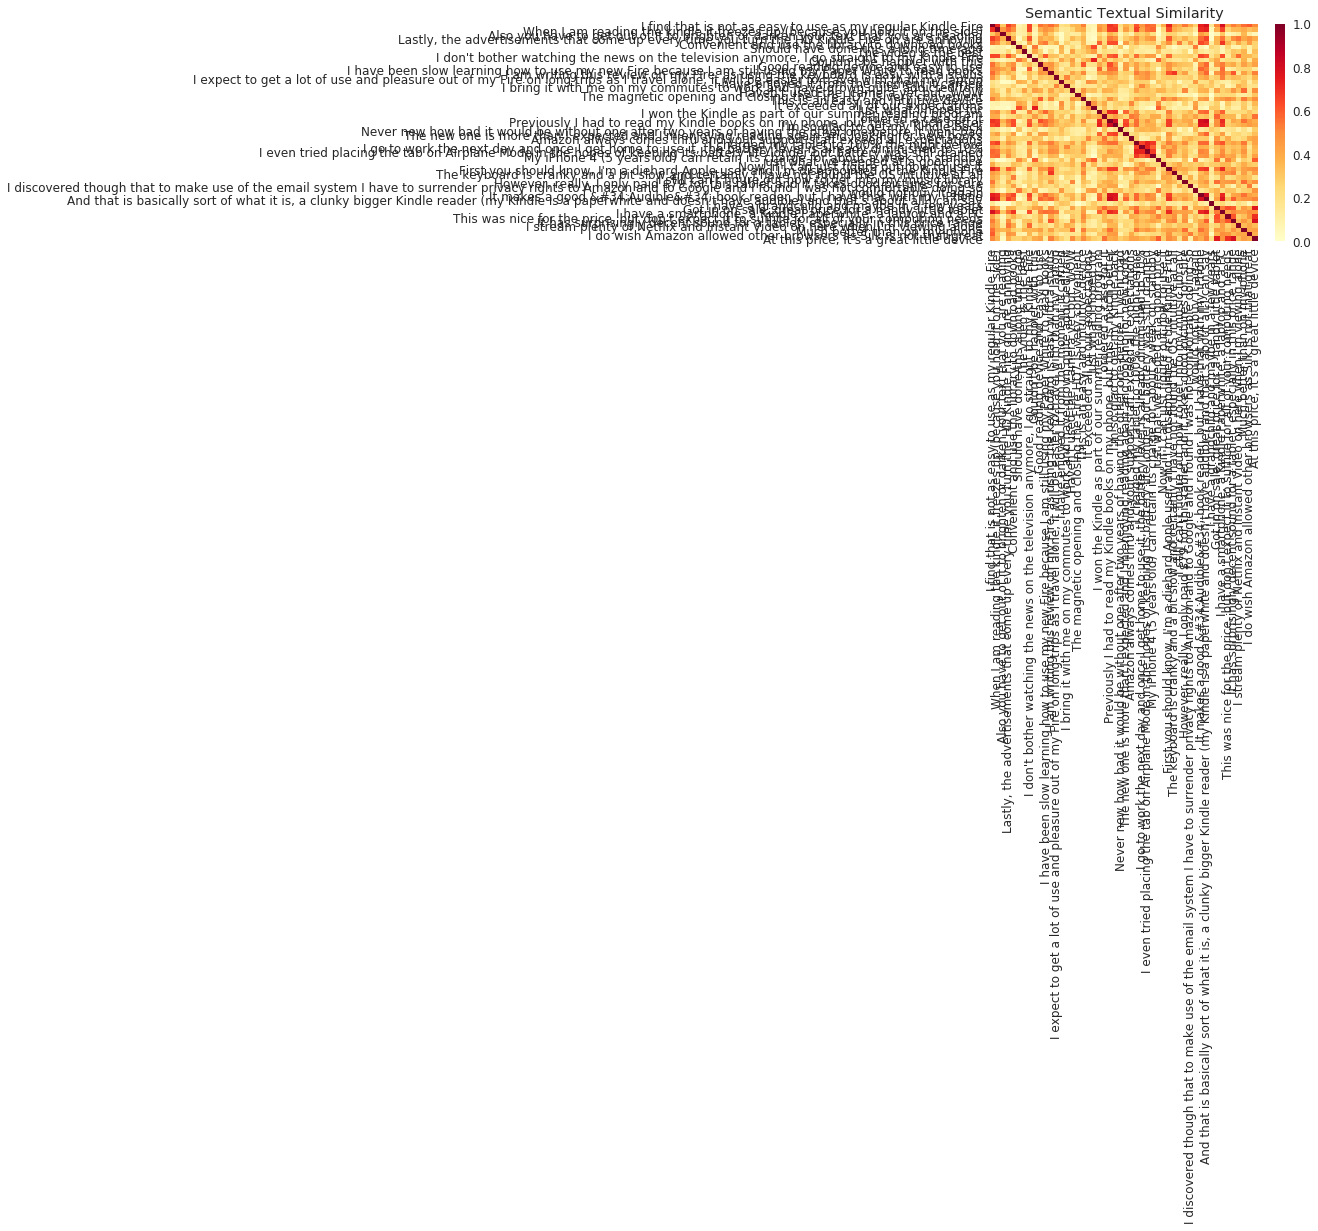

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(np.array(reviews['text'].tolist())[0:50],np.array(reviews['sentence_embedding'].tolist())[0:50],90)

In [29]:
label_s = np.array([])
label_w = np.array([])


def cluster_number(labels):
    return (len(set(labels)) - (1 if -1 in labels else 0))



In [66]:
# Clustering
time1 = time.time()
db_s = DBSCAN(eps=0.246, min_samples=n_min_pts, metric='canberra').fit(X1)
print('time for clustering sentence embeddings:', (time.time()-time1))
time1 = time.time()
db_w = DBSCAN(eps=0.246, min_samples=n_min_pts, metric='canberra').fit(X2)
print('time for clustering words embeddings:',(time.time()-time1))
# Get labels
labels_s = db_s.labels_.tolist()
labels_w = db_w.labels_.tolist()
reviews['label_db_sentence'] = labels_s
reviews['label_db_word'] = labels_w
n_sentence= cluster_number(labels_s)
n_words= cluster_number(labels_w)

time for clustering sentence embeddings: 22.16814923286438
time for clustering words embeddings: 21.511301040649414


In [65]:
print('total sentences:',len(list(labels_s)))
print('clusters for sentences:',n_sentence, 'noise:',list(labels_s).count(-1))
print('clusters for words:',n_words, 'noise:',list(labels_w).count(-1))

total sentences: 3355
clusters for sentences: 0 noise: 3355
clusters for words: 0 noise: 3355


In [117]:
def save_results_dir(product_name, method, params):
    dir_pre = '/home/betty35/桌面/Capstone/workspace/data_testing/output/'
    dir_ = dir_pre+product_name+'/'+method+'/'+params+'/'
    return dir_


def make_dir(dir_):
    if not os.path.exists(dir_):
        try:
            os.makedirs(dir_)
        except FileExistsError:
            pass

def clean_dir(dir_):
    for file_ in os.listdir(dir_):
        file_dir = os.path.join(dir_, file_)
        try:
            if os.path.isfile(file_dir):
                os.unlink(file_dir)
            elif os.path.isdir(file_dir): shutil.rmtree(file_dir)
        except Exception as e:
            print(e)

def make_or_clean_dir(dir_):
    make_dir(dir_)
    clean_dir(dir_)
    

In [18]:
product_title='Fire HD'
params='0.27-PCA10'
dir1 = save_results_dir(product_title,'dbscan',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,n_sentence):    
    temp = reviews.loc[reviews['label_db_sentence']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

noise_s = temp = reviews.loc[reviews['label_db_sentence']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

dir1 = save_results_dir(product_title,'dbscan',params+'/word')
make_or_clean_dir(dir1)
for i in range(0,n_words):
    temp = reviews.loc[reviews['label_db_word']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')
noise_s = temp = reviews.loc[reviews['label_db_word']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

In [ ]:
def cal_distance(X250):
    